In [2]:
import numpy as np
import os
import time

from lmfit.models import GaussianModel, Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture, metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg

import skimage
from skimage import io, transform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage import color

from PIL import Image, ImageDraw, ImageFilter, ImageOps
import copy
import cv2
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import logging
import glob
from radio_beam.commonbeam import getMinVolEllipse

from src.utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology,grainGenerate
from src.cfg import CfgAnglesNames, CfgBeamsNames, CfgDataset


In [6]:

def imdivide(image: np.ndarray, h: int, side: str) -> np.ndarray:
    """
    :param image: ndarray (height,width,channels)
    :param h: int scalar
    :param side: str 'left'
    :return: ndarray (height,width/2,channels)
    """
    #
    # возвращает левую или правую часть полученного изображения
    #
    height, width = image.shape
    sides = {'left': 0, 'right': 1}
    shapes = [(0, height - h, 0, width // 2), (0, height - h, width // 2, width)]
    shape = shapes[sides[side]]

    return image[shape[0]:shape[1], shape[2]:shape[3]]

def combine( image: np.ndarray, h: int, k=0.5) -> np.ndarray:
    """
    :param image: ndarray (height,width,channels)
    :param h: int scalar
    :param k: float scalar
    :return: ndarray (height,width/2,channels)
    """
    #
    #  накладывает левую и правые части изображения
    #  если k=1, то на выходе будет левая часть изображения, если k=0, то будет правая часть
    #
    left_img = imdivide(image, h, 'left')
    right_img = imdivide(image, h, 'right')

    l = k
    r = 1 - l
    gray = np.array(left_img) * l
    gray += np.array(right_img) * r

    return gray.astype('uint8')


In [12]:
folders=os.listdir('../data/dataset_cleaned')
images_paths=[glob.glob(f'../data/dataset_cleaned/{folder}/*') for folder in folders]

In [24]:
folders

['Ultra_Co11', 'Ultra_Co15', 'Ultra_Co25', 'Ultra_Co6_2', 'Ultra_Co8']

In [31]:
images_paths[0][0].split('\\')[0].split('/')[-1]

'Ultra_Co11'

In [22]:
images_paths[0][0].split('\\')[-1]

'Ultra_Co11-1.jpeg'

In [33]:
folders=os.listdir('../data/dataset_cleaned')
images_paths=[glob.glob(f'../data/dataset_cleaned/{folder}/*') for folder in folders]

new_path='../data/dataset_sub'

if not os.path.exists(new_path):
    os.mkdir(new_path)

for folder in folders:
    if not os.path.exists(new_path+'/'+folder):
        os.mkdir(new_path+'/'+folder)

for folder_images_path in images_paths:

    folder=folder_images_path[0].split('\\')[0].split('/')[-1]
    for image_path in folder_images_path:
        image_name=image_path.split('\\')[-1]




Ultra_Co11
Ultra_Co11-1.jpeg
Ultra_Co11
Ultra_Co11-100.jpeg
Ultra_Co11
Ultra_Co11-11.jpeg
Ultra_Co11
Ultra_Co11-12.jpeg
Ultra_Co11
Ultra_Co11-13.jpeg
Ultra_Co11
Ultra_Co11-14.jpeg
Ultra_Co11
Ultra_Co11-15.jpeg
Ultra_Co11
Ultra_Co11-16.jpeg
Ultra_Co11
Ultra_Co11-17.jpeg
Ultra_Co11
Ultra_Co11-18.jpeg
Ultra_Co11
Ultra_Co11-19.jpeg
Ultra_Co11
Ultra_Co11-2.jpeg
Ultra_Co11
Ultra_Co11-20.jpeg
Ultra_Co11
Ultra_Co11-21.jpeg
Ultra_Co11
Ultra_Co11-22.jpeg
Ultra_Co11
Ultra_Co11-23.jpeg
Ultra_Co11
Ultra_Co11-24.jpeg
Ultra_Co11
Ultra_Co11-25.jpeg
Ultra_Co11
Ultra_Co11-26.jpeg
Ultra_Co11
Ultra_Co11-27.jpeg
Ultra_Co11
Ultra_Co11-28.jpeg
Ultra_Co11
Ultra_Co11-29.jpeg
Ultra_Co11
Ultra_Co11-3.jpeg
Ultra_Co11
Ultra_Co11-30.jpeg
Ultra_Co11
Ultra_Co11-31.jpeg
Ultra_Co11
Ultra_Co11-32.jpeg
Ultra_Co11
Ultra_Co11-33.jpeg
Ultra_Co11
Ultra_Co11-34.jpeg
Ultra_Co11
Ultra_Co11-35.jpeg
Ultra_Co11
Ultra_Co11-37.jpeg
Ultra_Co11
Ultra_Co11-38.jpeg
Ultra_Co11
Ultra_Co11-39.jpeg
Ultra_Co11
Ultra_Co11-4.jpeg
Ultra_Co11
Ul

In [2]:
img=io.imread('images/artif/mixer/photo_2022-11-22_22-36-22.jpg')
# i=grainPreprocess.image_preprocess(img)

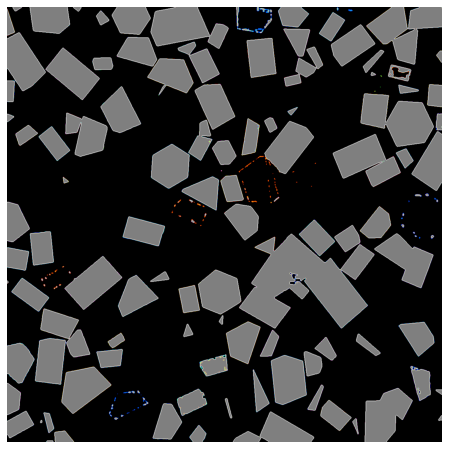

In [17]:
grainShow.img_show(i,N=8)
plt.show()

In [5]:
io.imsave('mixer_preprocess_new.png',res)

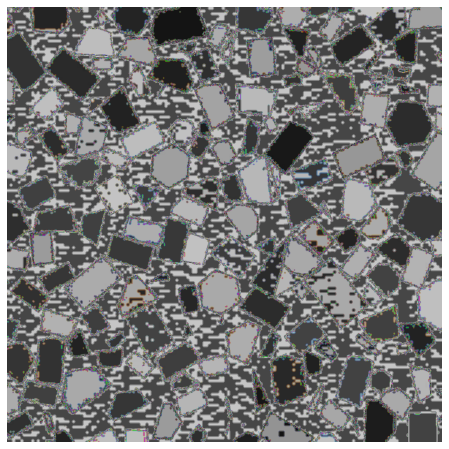

In [4]:
unsigned_image = util.img_as_ubyte(img)
if len(unsigned_image.shape) < 3:
    unsigned_image = unsigned_image[..., np.newaxis]
denoised = filters.rank.median(unsigned_image, ball(3))
# binary = grainPreprocess.do_otsu(denoised)
binary=denoised
grad = abs(filters.rank.gradient(binary, ball(1)))
bin_grad = (1 - binary + grad) * 127
res=bin_grad

grainShow.img_show(res,N=8)
plt.show()

In [8]:
images=glob.glob('images/artif/mixer/*')
images=[io.imread(name) for name in images]
step=2

all_original_angles = []
for image in images:

    original_angles = grainMark.get_angles(image)

    for angle in original_angles:
        all_original_angles.append(angle)

angles, angles_set, dens_curve = grainStats.stats_preprocess(all_original_angles, step)

x = angles_set.astype(np.float64)
y = dens_curve

norm = np.sum(y)
y = y / norm

(x_gauss, y_gauss), mus, sigmas, amps = grainApprox.bimodal_gauss_approx(x, y)

# text = grainGenerate.angles_legend(len(images_list), names[i], types_dict[names[i]], step, mus, sigmas,
#                                    amps, norm)
#
# xy_gauss.append((x_gauss, y_gauss))
# xy_scatter.append((x, y))
# xy_gauss_data.append((
#     (mus[0], sigmas[0], amps[0]),
#     (mus[1], sigmas[1], amps[1])
# ))
#
# texts.append(text)

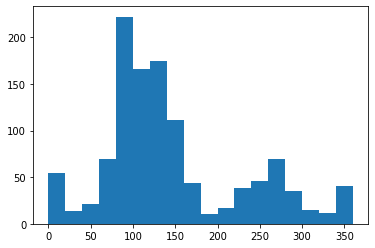

In [13]:
plt.hist(angles,bins=18)
plt.savefig('распределение углов исскуственное грубое_mixer.png')

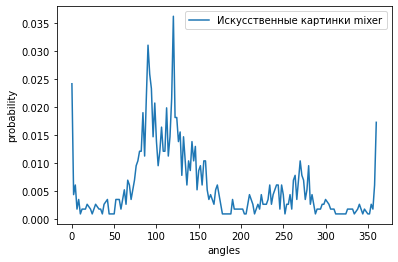

In [16]:
dens=np.array(dens_curve)/sum(dens_curve)
plt.plot(angles_set,dens)
plt.xlabel('angles')
plt.ylabel('probability')
plt.legend(['Искусственные картинки mixer'])
plt.savefig('углы_искусственные_mixer.png')
plt.show()

In [ ]:
io.imsave('atfir_preprocess.png',i)